In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, dayofweek, month, count, avg, sum as sum_col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import mlflow.spark

# Create Spark session
spark = SparkSession.builder \
    .appName("SocialMediaAnalysis") \
    .getOrCreate()

## Downloading the Dataset

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, dayofweek, month, from_unixtime, to_timestamp, when

# Create Spark session
spark = SparkSession.builder.appName("RedditEngagementAnalysis").getOrCreate()

# Load Reddit post data
# 📥 Load Reddit Posts CSV into Spark DataFrame
df_post_reddit = spark.read.format("csv") \
    .option("header", "true") \
    .option("multiLine", True) \
    .option("escape", "\"") \
    .load("dbfs:/FileStore/shared_uploads/mwa47@mail.aub.edu/reddit_posts_df.csv")
    
df_comments_reddit = spark.read.format("csv") \
    .option("header", "true") \
    .option("multiLine", True) \
    .option("escape", "\"") \
    .load("dbfs:/FileStore/shared_uploads/mwa47@mail.aub.edu/reddit_post_comments.csv")

# Load Twitter post data
df_tweet = spark.read.format("csv") \
    .option("header", "true") \
    .option("multiLine", True) \
    .option("escape", "\"") \
    .load("dbfs:/FileStore/shared_uploads/mwa47@mail.aub.edu/twitter_data/twitter_data_science_tweets.csv")

df_users_twitter = spark.read.format("csv") \
    .option("header", "true") \
    .option("multiLine", True) \
    .option("escape", "\"") \
    .load("dbfs:/FileStore/shared_uploads/mwa47@mail.aub.edu/twitter_data/twitter_data_science_users.csv")

In [0]:
print(df_post_reddit.show(5))

+-------+--------------------+--------------------+------------------+------------+-----+------------+------------+------------+
|post_id|               title|                text|            author| created_utc|score|num_comments|upvote_ratio|content_type|
+-------+--------------------+--------------------+------------------+------------+-----+------------+------------+------------+
|1k44mgg|Weekly Entering &...| \n\nWelcome to t...|     AutoModerator|1745208103.0|    7|          27|         1.0|        text|
|1i5inrb|Weekly Entering &...| \n\nWelcome to t...|     AutoModerator|1737349304.0|   13|          46|         1.0|        text|
|1k6tz9y|Leadership said t...|Our DS group was ...|DeepNarwhalNetwork|1745505817.0|  149|          63|        0.94|        text|
|1k6wi45|What are some uni...|                null|       Voldemort57|1745511916.0|   61|         111|        0.84|       other|
|1k6za0y|   Signs of burnout?|Hey all,\n\nI pos...|       thro0away12|1745518614.0|   25|        

In [0]:
print(df_comments_reddit.show(5))

+----------+-------+-------------------+--------------------+-----+------------+
|comment_id|post_id|             author|                text|score| created_utc|
+----------+-------+-------------------+--------------------+-----+------------+
|   mo9oc75|1k44mgg| Timely_Market_4377|I have a healthca...|    3|1745248345.0|
|   moayqxi|1k44mgg|          gauchoezm|Hi everyone, \n\n...|    2|1745262820.0|
|   moaz4yd|1k44mgg|  photosynthescythe|I have a strange ...|    2|1745262936.0|
|   mofc3mq|1k44mgg|    Occam5_cha1nsaw|Hey everyone,\nI'...|    2|1745327668.0|
|   moc9pqw|1k44mgg|Itchy-Amphibian9756|Ok so after some ...|    1|1745277515.0|
+----------+-------+-------------------+--------------------+-----+------------+
only showing top 5 rows

None


## Data Preparation

In this part, we will prepare our data to be ready for machine learning. This will include the following steps:
- **Feature Engineering**:  
  We will create 3 new time-based features — `hour`, `month`, and `day_of_week` — extracted from the `created_utc` timestamp column. These features will help us gain insights into when each post was created, and how time-related patterns may influence engagement. Also `engagement_metric` was created based on the score and number of comments
- **Data Cleaning**:  
  We will cast all numerical features and the target variable to the appropriate data types (e.g., `double`) and remove any rows with missing values in key columns. This ensures that the data fed into the machine learning models is clean, consistent, and ready for vector assembly.

In [0]:
# 💡 Create an engagement metric: score + num_comments
df = df_post_reddit.withColumn("engagement_metric", col("score") + col("num_comments"))

# Drop missing engagement rows (shouldn't happen, but just in case)
df = df.dropna(subset=["engagement_metric"])
df = df.withColumn("engagement_metric", col("engagement_metric").cast("double"))

# Convert created_utc (epoch) into proper timestamp
df = df.withColumn("timestamp", to_timestamp(from_unixtime(col("created_utc"))))

# Extract time features
df = df.withColumn("hour", hour(col("timestamp")))
df = df.withColumn("day_of_week", dayofweek(col("timestamp")))
df = df.withColumn("month", month(col("timestamp")))

# Print schema and preview
df.printSchema()
df.select("post_id", "engagement_metric", "timestamp", "hour", "day_of_week").show(5)

root
 |-- post_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- author: string (nullable = true)
 |-- created_utc: string (nullable = true)
 |-- score: string (nullable = true)
 |-- num_comments: string (nullable = true)
 |-- upvote_ratio: string (nullable = true)
 |-- content_type: string (nullable = true)
 |-- engagement_metric: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- month: integer (nullable = true)

+-------+-----------------+-------------------+----+-----------+
|post_id|engagement_metric|          timestamp|hour|day_of_week|
+-------+-----------------+-------------------+----+-----------+
|1k44mgg|             34.0|2025-04-21 04:01:43|   4|          2|
|1i5inrb|             59.0|2025-01-20 05:01:44|   5|          2|
|1k6tz9y|            212.0|2025-04-24 14:43:37|  14|          5|
|1k6wi45|            172.0|202

In [0]:
print(df.columns)

['post_id', 'title', 'text', 'author', 'created_utc', 'score', 'num_comments', 'upvote_ratio', 'content_type', 'engagement_metric', 'timestamp', 'hour', 'day_of_week', 'month']


In [0]:
num_rows = df.count()
num_cols = len(df.columns)

print(f"📊 Shape of df: ({num_rows}, {num_cols})")

📊 Shape of df: (300, 14)


In [0]:
# Casting all numerical features and the target variable to the appropriate data types (e.g., double)

numeric_cols = ['hour', 'day_of_week', 'month', "num_comments", "upvote_ratio", "engagement_metric"]

for colname in numeric_cols:
    df = df.withColumn(colname, col(colname).cast("double"))

In [0]:
# Checking the number of missing values

from pyspark.sql.functions import col, sum as _sum
import pandas as pd

# Compute null counts
null_counts = df.select([
    _sum(col(c).isNull().cast("int")).alias(c) for c in df.columns
]).toPandas().T.reset_index()

# Rename columns and sort
null_counts.columns = ["column", "null_count"]
null_counts = null_counts[null_counts["null_count"] > 0].sort_values(by="null_count", ascending=False)

# Display as pretty table
print("🧼 Null Count Per Column:")
print(null_counts.to_string(index=False))

🧼 Null Count Per Column:
column  null_count
  text          28


## EDA
In this part, we will perform exploratory data analysis to better understand the relationships between our features and the target variable. This will include the following:
- **Descriptive Statistics**:  
  Display summary statistics (mean, stddev, min, max) for all numerical features to get an overview of the data distribution.
- **Distribution Analysis**:  
  Plot histograms for all numerical features to observe their distributions and detect skewness, outliers, or imbalanced ranges.
- **Feature vs. Target Relationships**:  
  Generate scatterplots between each numerical feature and the target variable (`engagement_metric`) to visually explore potential correlations or nonlinear patterns.
- **Correlation Matrix**:  
  Display a heatmap of the Pearson correlation coefficients between numerical features to identify strongly related variables.


In [0]:
# Summary statistics
desc_pd = df.describe().toPandas()
# Expand display settings
pd.set_option('display.max_columns', None)  # show all columns
pd.set_option('display.width', None)        # don't wrap lines
pd.set_option('display.max_colwidth', None) # show full column values

# Print full describe DataFrame
print(desc_pd)

  summary  post_id  \
0   count      300   
1    mean     None   
2  stddev     None   
3     min  1i5inrb   
4     max  1k76c0v   

                                                                                               title  \
0                                                                                                300   
1                                                                                               None   
2                                                                                               None   
3                              "Hey, you have a second for a quick call? It will just take a minute"   
4  “Good at practical ML, weak on theory” — getting the same feedback everywhere. How do I fix this?   

                                                                                                                                                                                                                                                  

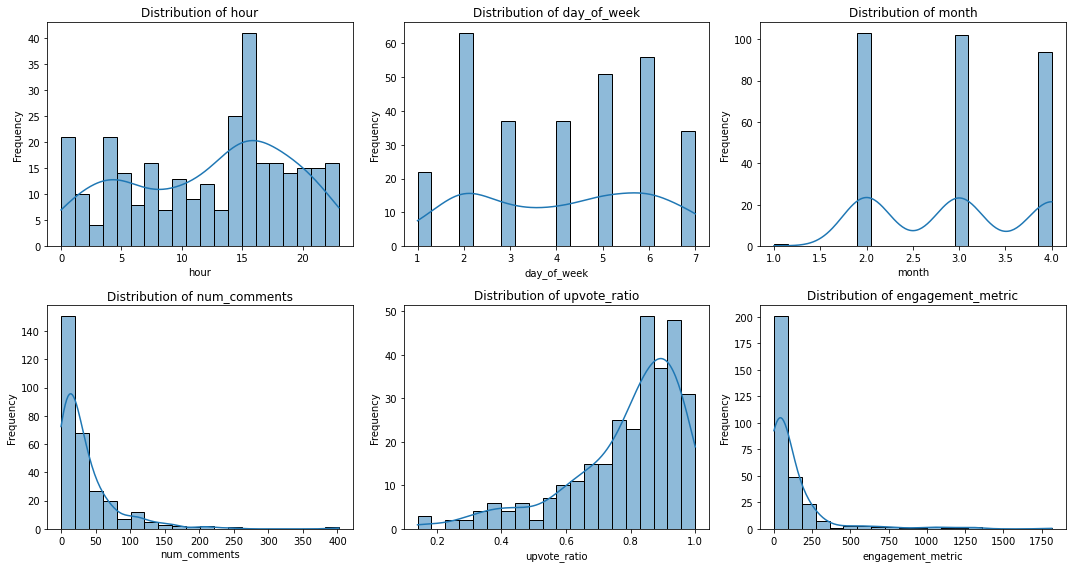

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Convert to pandas
df_numerical = df.select(numeric_cols).dropna().toPandas()

# Dynamically calculate number of subplots
n = len(df_numerical.columns)
cols = 3
rows = math.ceil(n / cols)

# Plot
plt.figure(figsize=(5 * cols, 4 * rows))

for i, col in enumerate(df_numerical.columns, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(df_numerical[col], bins=20, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

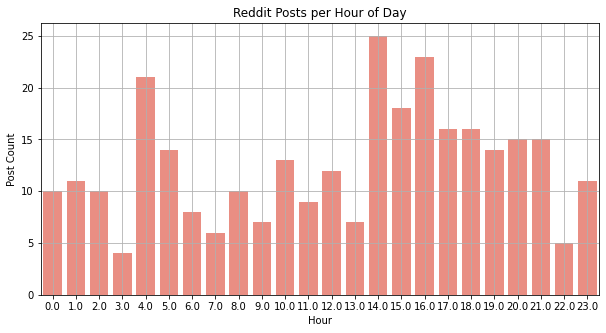

In [0]:
# Post Count by Hour
from pyspark.sql.functions import hour, from_unixtime

# Group and convert to pandas
posts_per_hour = df.groupBy("hour").count().orderBy("hour").toPandas()

# Now plot it
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(data=posts_per_hour, x="hour", y="count", color='salmon')
plt.title("Reddit Posts per Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Post Count")
plt.grid(True)
plt.show()

    hour  avg_engagement
0    0.0       66.600000
1    1.0      171.454545
2    2.0      259.600000
3    3.0       18.500000
4    4.0       95.523810
5    5.0      125.071429
6    6.0       48.750000
7    7.0       34.166667
8    8.0       68.600000
9    9.0      213.285714
10  10.0       62.615385
11  11.0       69.111111
12  12.0      157.416667
13  13.0      248.285714
14  14.0      185.280000
15  15.0       96.833333
16  16.0      121.000000
17  17.0      122.437500
18  18.0      151.312500
19  19.0      220.285714
20  20.0      114.533333
21  21.0       61.200000
22  22.0       33.400000
23  23.0      139.818182


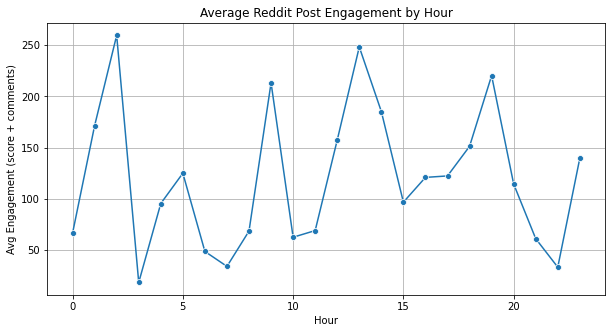

In [0]:
# Hourly engagement pattern
from pyspark.sql.functions import avg, col

# ✅ Step 1: Aggregate average engagement by hour
hourly_patterns = df.groupBy("hour").agg(
    avg("engagement_metric").alias("avg_engagement")
).orderBy(col("hour"))

# ✅ Step 2: Convert to Pandas
pd_hourly = hourly_patterns.toPandas()
print(pd_hourly)

# Plot Average Engagement by Hour
plt.figure(figsize=(10, 5))
sns.lineplot(data=pd_hourly, x="hour", y="avg_engagement", marker="o")
plt.title("Average Reddit Post Engagement by Hour")
plt.xlabel("Hour")
plt.ylabel("Avg Engagement (score + comments)")
plt.grid(True)
plt.show()

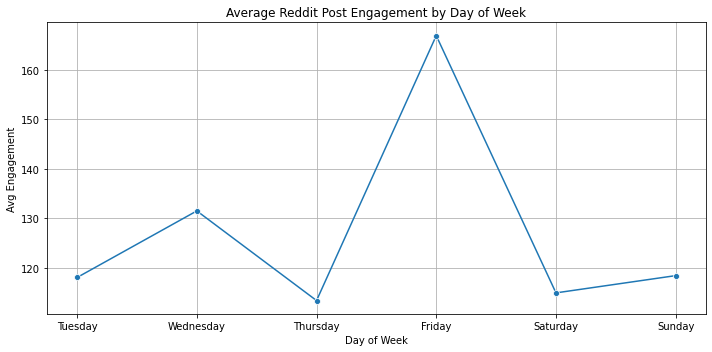

In [0]:
import calendar
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Group and average by day of week
day_of_week = df.groupBy("day_of_week").agg(
    avg("engagement_metric").alias("avg_engagement")
).orderBy("day_of_week").toPandas()

# Step 2: Filter valid days (0 to 6)
day_of_week = day_of_week[day_of_week["day_of_week"].between(0, 6)]

# Step 3: Map to weekday names
day_of_week["day_label"] = day_of_week["day_of_week"].astype(int).apply(lambda x: calendar.day_name[x])

# Step 4: Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=day_of_week, x="day_label", y="avg_engagement", marker="o")
plt.title("Average Reddit Post Engagement by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Avg Engagement")
plt.grid(True)
plt.tight_layout()
plt.show()

/databricks/python/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 128338 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/databricks/python/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 128338 missing from current font.
  font.set_text(s, 0, flags=flags)


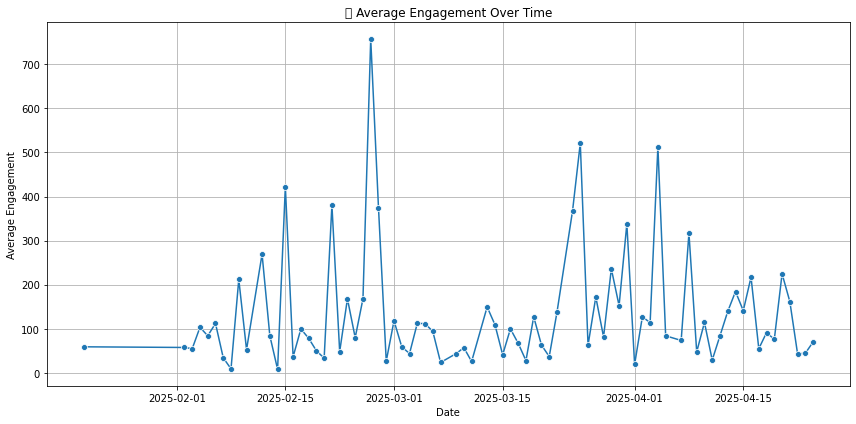

In [0]:
# A time-series chart showing engagement patterns over time

# ✅ Step 0: Imports
from pyspark.sql.functions import from_unixtime, to_timestamp, date_trunc, col, avg

# ✅ Step 1: Convert UNIX timestamp to proper Spark timestamp
df = df.withColumn(
    "timestamp", to_timestamp(from_unixtime(col("created_utc").cast("long")))
)

# ✅ Step 2: Truncate timestamp to daily granularity
df_time = df.withColumn("datetime", date_trunc("day", col("timestamp")))

# ✅ Step 3: Ensure engagement_metric is a numeric column
df_time = df_time.withColumn("engagement_metric", col("engagement_metric").cast("double"))

# ✅ Step 4: Aggregate average engagement by day
df_time_agg = df_time.groupBy("datetime").agg(
    avg("engagement_metric").alias("avg_engagement")
).orderBy("datetime")

# ✅ Step 5: Convert to Pandas for plotting
df_time_pd = df_time_agg.dropna().toPandas()
df_time_pd["datetime"] = pd.to_datetime(df_time_pd["datetime"])

# ✅ Step 6: Plot the time-series chart
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_time_pd, x="datetime", y="avg_engagement", marker='o')
plt.title("🕒 Average Engagement Over Time")
plt.xlabel("Date")
plt.ylabel("Average Engagement")
plt.grid(True)
plt.tight_layout()
plt.show()

+------------+------------------+
|content_type|    avg_engagement|
+------------+------------------+
|        link| 92.27272727272727|
|       other| 81.38461538461539|
|        text|108.73076923076923|
|       image|            464.75|
+------------+------------------+

None
/databricks/python/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 128202 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/databricks/python/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 128202 missing from current font.
  font.set_text(s, 0, flags=flags)


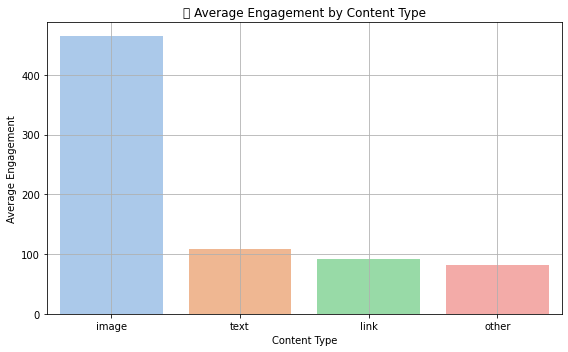

In [0]:
# Calculating average engagement by content_type and show a comparative chart of different content types’ performance
from pyspark.sql.functions import avg, col
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import avg

avg_engagement_df = df.groupBy("content_type").agg(
    avg("engagement_metric").alias("avg_engagement")
)

print(avg_engagement_df.show())

# Aggregate average engagement per content type
content_perf_df = avg_engagement_df.orderBy(col("avg_engagement").desc())

# Convert to Pandas for plotting
content_perf_pd = content_perf_df.toPandas()

# Plot bar chart
plt.figure(figsize=(8, 5))
sns.barplot(data=content_perf_pd, x="content_type", y="avg_engagement", palette="pastel")
plt.title("📊 Average Engagement by Content Type")
plt.xlabel("Content Type")
plt.ylabel("Average Engagement")
plt.grid(True)
plt.tight_layout()
plt.show()

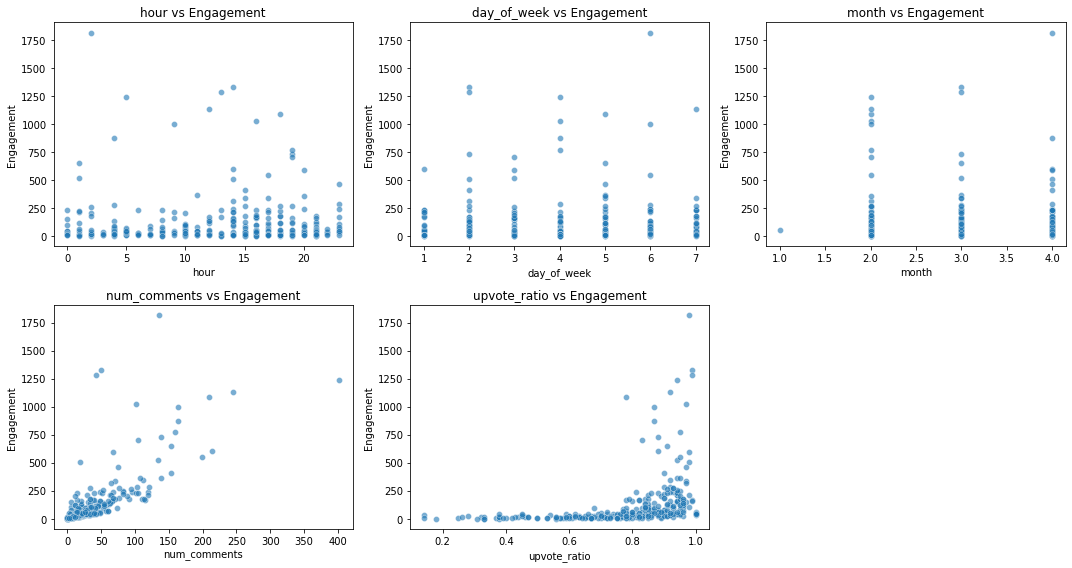

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Exclude target variable
features_to_plot = [col for col in numeric_cols if col != "engagement_metric"]

# Dynamically compute grid size
n = len(features_to_plot)
cols = 3
rows = math.ceil(n / cols)

plt.figure(figsize=(5 * cols, 4 * rows))

for i, col in enumerate(features_to_plot, 1):
    plt.subplot(rows, cols, i)
    sns.scatterplot(data=df_numerical, x=col, y="engagement_metric", alpha=0.6)
    plt.title(f"{col} vs Engagement")
    plt.xlabel(col)
    plt.ylabel("Engagement")

plt.tight_layout()
plt.show()

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


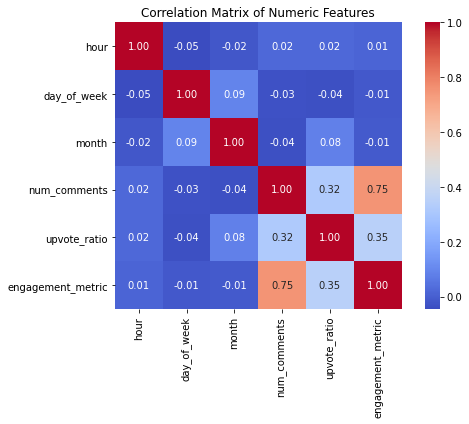

In [0]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt

# Assemble features into vector
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features_corr")
df_vec = assembler.transform(df).select("features_corr")

# Compute correlation matrix
correlation_matrix = Correlation.corr(df_vec, "features_corr", method="pearson").head()[0]

# Convert to Pandas DataFrame
corr_array = correlation_matrix.toArray()
corr_df = pd.DataFrame(corr_array, columns=numeric_cols, index=numeric_cols)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()


## Machine Learning Pipeline

In this section, we build and evaluate two different machine learning models to predict the engagement level of Reddit posts. The entire pipeline includes feature assembly, model training, and evaluation. The models used are:
- **Linear Regression**:  
  A simple and interpretable model that assumes a linear relationship between the input features and the target variable (`engagement_metric`). We applied **MinMaxScaler** before fitting this model to normalize feature values. This model provides valuable insights into how each feature linearly contributes to the target, and we visualized its coefficients and statistical significance (p-values).
- **Random Forest Regressor**:  
  A powerful ensemble model that builds multiple decision trees and averages their predictions. It can capture complex, nonlinear interactions between features without requiring scaling. We used this model without normalization, and explored **feature importances** to understand which variables had the strongest impact on engagement.  

After training both models, we evaluated them using **Root Mean Squared Error (RMSE)** and tracked their performance using **MLflow** for comparison. This allows us to assess trade-offs between interpretability and predictive accuracy.

In [0]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
import mlflow
import mlflow.spark

# ✅ Define feature columns
numerical_cols = ['hour', 'day_of_week', 'month', 'num_comments', 'upvote_ratio']
categorical_col = 'content_type'

# ✅ Index the categorical column
content_type_indexer = StringIndexer(inputCol=categorical_col, outputCol=f"{categorical_col}_idx")

# ✅ Combine numerical + indexed categorical features
feature_cols = numerical_cols + [f"{categorical_col}_idx"]

# ✅ Assemble features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# ✅ Scale features
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

# ✅ Linear Regression model
lr = LinearRegression(featuresCol="scaled_features", labelCol="engagement_metric")

# ✅ Build pipeline
pipeline = Pipeline(stages=[content_type_indexer, assembler, scaler, lr])

# ✅ Split the data
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# ✅ MLflow run
if mlflow.active_run():
    mlflow.end_run()
mlflow.start_run(run_name="Engagement_Prediction")

# ✅ Train
model = pipeline.fit(train_data)

# ✅ Predict
predictions = model.transform(test_data)

# ✅ Evaluate
evaluator = RegressionEvaluator(
    labelCol="engagement_metric",
    predictionCol="prediction",
    metricName="rmse"
)
rmse = evaluator.evaluate(predictions)

# ✅ Log to MLflow
mlflow.log_param("model", "LinearRegression")
mlflow.log_param("features_used", ", ".join(feature_cols))
mlflow.log_metric("rmse", rmse)
mlflow.spark.log_model(model, "model")

mlflow.end_run()

print(f"✅ Final RMSE: {rmse:.2f}")

✅ Final RMSE: 71.38


/databricks/python/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 128270 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/databricks/python/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 128270 missing from current font.
  font.set_text(s, 0, flags=flags)


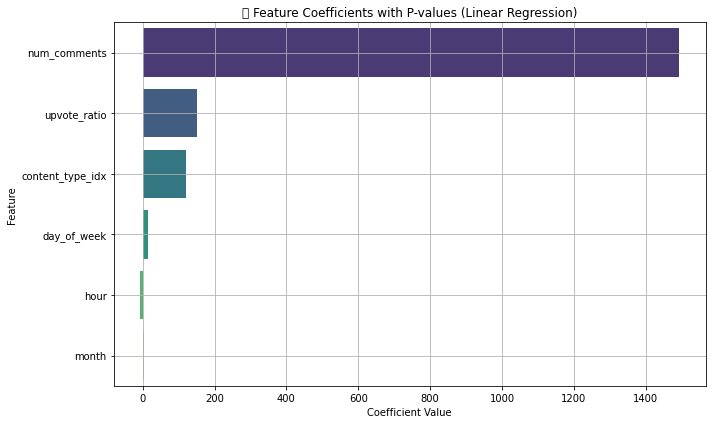

In [0]:
# Extract trained stages
indexer_model = model.stages[0]     
assembler_model = model.stages[1]      
scaler_model = model.stages[2]        
lr_model = model.stages[3]             

# Extract original features
features = assembler_model.getInputCols()

# Get coefficients and p-values
summary = lr_model.summary
coefficients = lr_model.coefficients
p_values = summary.pValues[1:]  # Remove intercept

coeff_df = pd.DataFrame({
    "feature": features,
    "coefficient": coefficients,
    "p_value": p_values
}).sort_values("coefficient", key=abs, ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=coeff_df, x="coefficient", y="feature", palette="viridis")
plt.title("🔎 Feature Coefficients with P-values (Linear Regression)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.grid(True)
plt.tight_layout()
plt.show()

In [0]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
import mlflow
import mlflow.spark

# ✅ Define features
numerical_cols = ['hour', 'day_of_week', 'month', 'num_comments', 'upvote_ratio']
categorical_col = 'content_type'

# ✅ Index categorical column
indexer = StringIndexer(inputCol=categorical_col, outputCol=f"{categorical_col}_idx")

# ✅ Final feature columns (numerical + indexed categorical)
feature_cols = numerical_cols + [f"{categorical_col}_idx"]

# ✅ Assemble features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# ✅ Define Random Forest model
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="engagement_metric",
    numTrees=200,
    maxDepth=10,
    seed=42
)

# ✅ Create pipeline
pipeline = Pipeline(stages=[indexer, assembler, rf])

# ✅ Train-test split
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# ✅ MLflow run
if mlflow.active_run():
    mlflow.end_run()
mlflow.start_run(run_name="RandomForest_With_ContentType")

# ✅ Train model
model = pipeline.fit(train_data)

# ✅ Predict
predictions = model.transform(test_data)

# ✅ Evaluate
evaluator = RegressionEvaluator(
    labelCol="engagement_metric",
    predictionCol="prediction",
    metricName="rmse"
)
rmse = evaluator.evaluate(predictions)

# ✅ Log to MLflow
mlflow.log_param("model", "RandomForestRegressor")
mlflow.log_param("features_used", ", ".join(feature_cols))
mlflow.log_metric("rmse", rmse)
mlflow.spark.log_model(model, "random_forest_with_content_type")

# ✅ End MLflow run
mlflow.end_run()

print(f"Random Forest RMSE (with content_type): {rmse:.2f}")

Random Forest RMSE (with content_type): 83.65


/databricks/python/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 127794 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/databricks/python/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 127794 missing from current font.
  font.set_text(s, 0, flags=flags)


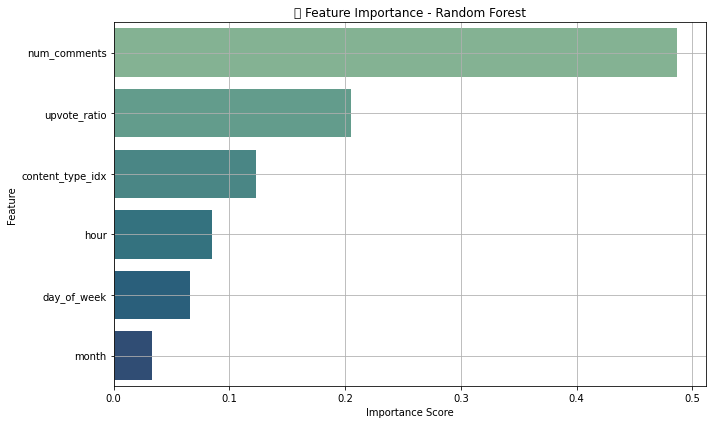

<Figure size 432x288 with 0 Axes>

In [0]:
# Required imports
import tempfile
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ✅ Feature names used in model
feature_cols = ['hour', 'day_of_week', 'month', 'num_comments', 'upvote_ratio', 'content_type_idx']

# ✅ Extract the trained Random Forest model from pipeline
rf_model = model.stages[-1]  # stage 2 if full pipeline = [indexer, assembler, rf]

# ✅ Get importances
importances = rf_model.featureImportances.toArray()

# ✅ Build DataFrame for plotting
feature_importance_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# ✅ Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x="importance", y="feature", palette="crest")
plt.title("🌲 Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ (Optional) Log to MLflow
with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp:
    plt.savefig(tmp.name)
    mlflow.log_artifact(tmp.name, "feature_importance_plot")

## Performance Optimization with Partitioning  
In this section, we demonstrate how partitioning in Spark can significantly improve the performance of data transformations and storage operations. Using our Reddit engagement dataset, we compare baseline aggregation performance with repartitioned and coalesced data, and show how partitioning by relevant columns (like `hour` or `month`) leads to faster computation and more efficient disk writes.


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import month
import time

# ✅ 1. Setup Spark Session
spark = SparkSession.builder \
    .appName("PartitioningDemo") \
    .getOrCreate()

# ✅ 3. Baseline aggregation
start = time.time()
df.groupBy("content_type").count().collect()
print("⏱️ Baseline aggregation:", time.time() - start)

# ✅ 4. Repartition by content_type
df2 = df.repartition(5, "content_type")
start = time.time()
df2.groupBy("content_type").count().collect()
print("⏱️ Repartitioned (5):", time.time() - start)

# ✅ 5. Coalesce to fewer partitions
df3 = df2.coalesce(5)
start = time.time()
df3.groupBy("content_type").count().collect()
print("⏱️ Coalesced (5):", time.time() - start)

# ✅ 6. Write-time partitioning (replace 'timestamp' and 'platform' with actual columns)
df.withColumn("month", month("timestamp")) \
    .write \
    .mode("overwrite") \
    .partitionBy("month") \
    .parquet("output/partitioned_posts")

⏱️ Baseline aggregation: 0.47664928436279297
⏱️ Repartitioned (5): 0.393369197845459
⏱️ Coalesced (5): 0.36579155921936035


In [0]:
from pyspark.sql.functions import avg, count
import time

# ✅ Step 0: Aggregate comments data (replace df_comments_agg with this)
df_comments_agg = df_comments_reddit.groupBy("post_id").agg(
    avg("score").alias("avg_comment_score"),
    count("*").alias("comment_count")
)

# ✅ Step 1: Baseline Join (no partitioning)
start = time.time()
df_joined_baseline = df_post_reddit.join(df_comments_agg, on="post_id", how="left")
df_joined_baseline.count()  # trigger execution
print("⏱️ Baseline join time:", time.time() - start)

# ✅ Step 2: Repartition before join
df_post_part = df_post_reddit.repartition("post_id")
df_comm_part = df_comments_agg.repartition("post_id")

start = time.time()
df_joined_partitioned = df_post_part.join(df_comm_part, on="post_id", how="left")
df_joined_partitioned.count()
print("⏱️ Repartitioned join time:", time.time() - start)

⏱️ Baseline join time: 1.0921375751495361
⏱️ Repartitioned join time: 0.6650238037109375
